In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from cleaning_pipeline import goods, full_prod_orders

# Use to reimport module if you make change to the .py
# importlib.reload(cleaning_pipeline)

In [5]:
from __future__ import print_function
from sklearn.cluster import KMeans
from PlottingFunctions import plot_inertia, plot_silhouette

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import seaborn as sns

In [180]:
def plot_PCA(df, scale=True, plot_x='PC1', plot_y='PC2', return_df=False):
    '''Scale a dataframe and calculate its principal components
    
    Args: 
        takes a dataframe 
        
    Returns:
        the explained variance ratio for all components
        the plot of the first two components

    '''
    pc_list = range(1, len(df.columns.tolist())+1)
    pc_number = ['PC'+str(i) for i in pc_list]
    
    # Scale data 
    if scale:
        scaler = StandardScaler()
        scaler.fit(df)
        df = scaler.transform(df)


    # build PCA
    pca = PCA()
    principalComponents = pca.fit_transform(df)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = pc_number)

    # Plot PCA
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    ax.scatter(principalDf[[plot_x]],
               principalDf[[plot_y]],
                s = 50)
    
    
    if return_df:
        return pd.DataFrame(principalComponents)
#         df_return = pd.DataFrame(principalComponents)
#         var_ratio = pca.explained_variance_ratio_.tolist()
#         return (df_return, var_ratio)

    return pca.explained_variance_ratio_

## Cluster based on aggregate stats from Jordan
- K-Means with k = 3 based on elbow plot
- PCA of full and reduced datasets

In [28]:
user_summary = pd.read_csv('../data/user_summary.csv')
user_summary = user_summary.drop(['mode_day_of_week', 'mode_hour_of_day'],axis=1)

In [25]:
kmeans = KMeans()
kmeans.set_params(n_clusters=3)
kmeans.fit(user_summary)

# plot_inertia(kmeans, user_summary.iloc[:,0:2].values, range(1, 10))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

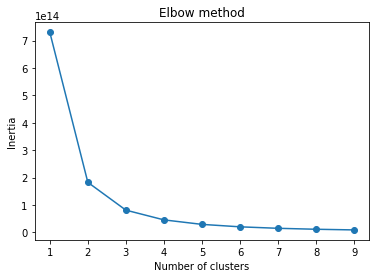

In [23]:
# Use K = 3
plot_inertia(kmeans, user_summary, range(1, 10))

In [28]:
# K-means evenly split the groups. Seems suspicious
pd.Series(kmeans.labels_)

1    68857
2    68737
0    68615
dtype: int64

[3.35896650e-01 2.38474891e-01 1.20463163e-01 9.62285285e-02
 7.81324471e-02 5.09846463e-02 2.76148521e-02 2.00146404e-02
 9.95736706e-03 7.47169529e-03 5.59076239e-03 4.01561586e-03
 1.85522603e-03 1.71216164e-03 1.20478234e-03 3.66078414e-04
 1.64917395e-05]


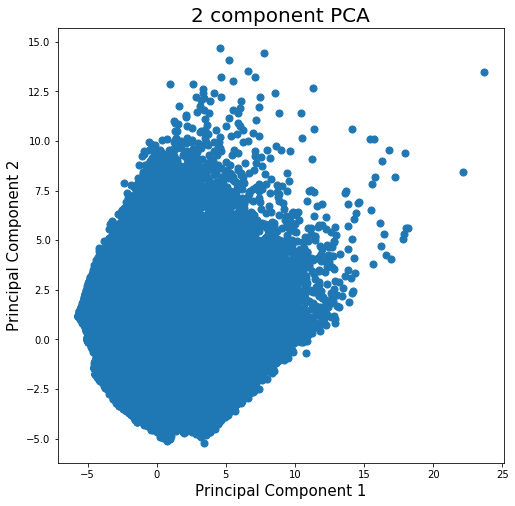

In [29]:
pca_users = user_summary.drop('user_id', axis=1)
plot_PCA(pca_users)

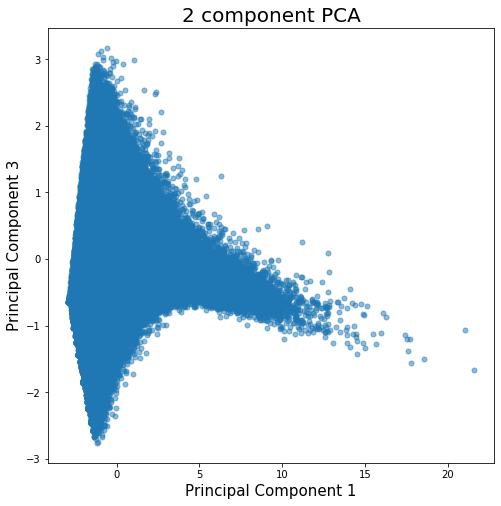

In [101]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 3', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalDf[['PC1']],
           principalDf[['PC3']],
            s = 25, alpha=0.5)

[5.99229480e-01 1.94823481e-01 9.95653124e-02 8.65114432e-02
 1.98231776e-02 4.71063083e-05]


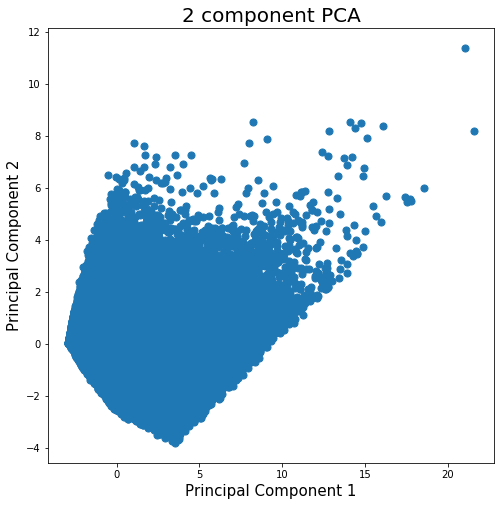

In [30]:
# Make reduced PCA using fewer stats
new_list = user_summary.columns.tolist()[:-1]
indices = [1,2,6,10,12,-1]
subset_list = [new_list[i] for i in indices]
reduced_users = user_summary[subset_list]

plot_PCA(reduced_users)

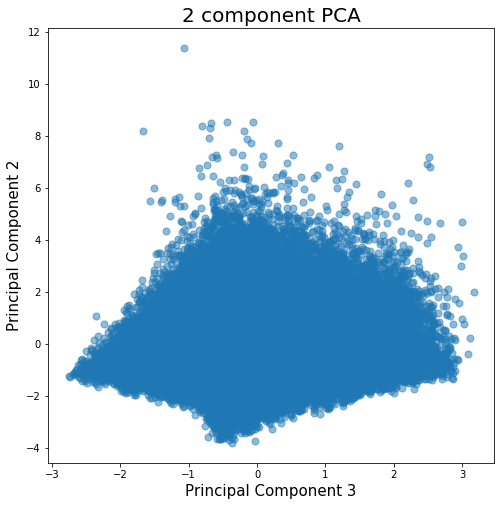

In [100]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 3', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
ax.scatter(principalDf[['PC3']],
           principalDf[['PC2']],
            s = 50, alpha=0.5)

## Clustering based on Department


1. Make a table with number items bought in each dept  by customer
2. Make a table with items bought per aisle by each customer
2. create a purchase summary matrix:
    - columns representing each product available for purchase
    - rows representing each customer
    - then use sparse matrix?
    
    

In [2]:
dept_user_df = full_prod_orders.groupby(['user_id','department'], as_index=False).product_id.agg('count')
dept_user_df = dept_user_df.pivot(index='user_id', columns='department', values = 'product_id')
dept_user_df = dept_user_df.fillna(0)

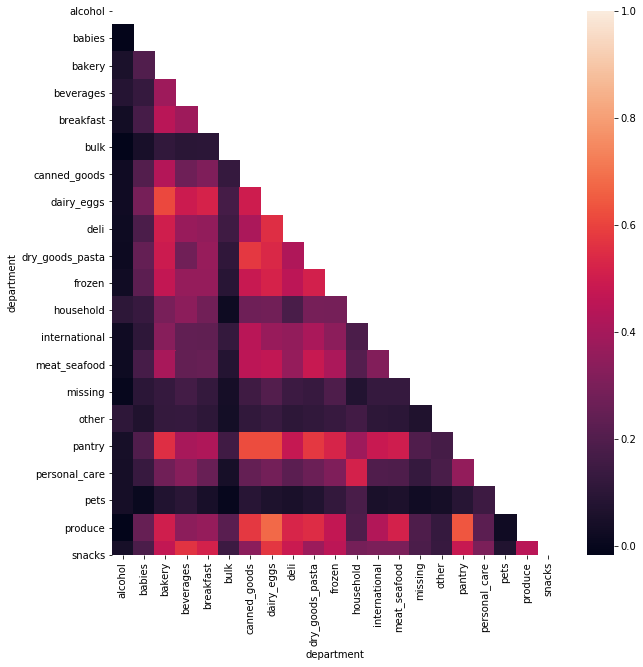

In [5]:
# Which departments are correlated with each other?
plt.figure(figsize=(10,10))
matrix_ = np.triu(dept_user_df.corr())
sns.heatmap(dept_user_df.corr(), mask=matrix_)

In [57]:
corr_ = dept_user_df.corr()
corr_.produce.sort_values(ascending=False)

department
produce            1.000000
dairy_eggs         0.681753
pantry             0.641524
canned_goods       0.575268
dry_goods_pasta    0.549380
deli               0.529558
meat_seafood       0.519165
bakery             0.503731
frozen             0.470107
snacks             0.446274
international      0.431822
breakfast          0.363398
beverages          0.344518
babies             0.252905
personal_care      0.221652
bulk               0.218941
missing            0.191358
household          0.190607
other              0.126151
pets               0.026537
alcohol           -0.016976
Name: produce, dtype: float64

In [67]:
corr_.other.sort_values(ascending=False)

department
other              1.000000
personal_care      0.178739
pantry             0.166465
household          0.161164
dairy_eggs         0.134856
frozen             0.130909
snacks             0.130750
beverages          0.126744
produce            0.126151
bakery             0.124787
canned_goods       0.116117
dry_goods_pasta    0.114326
alcohol            0.109088
deli               0.104364
international      0.104023
breakfast          0.102228
meat_seafood       0.100583
missing            0.067892
babies             0.067667
pets               0.042348
bulk               0.036791
Name: other, dtype: float64

#### Create Percentage Dept_user-df

In [3]:
dept_user_df['total_items'] = dept_user_df.sum(axis=1)
cols = dept_user_df.columns[:-1]
dept_percent_df = dept_user_df[cols].div(dept_user_df.total_items, axis=0)

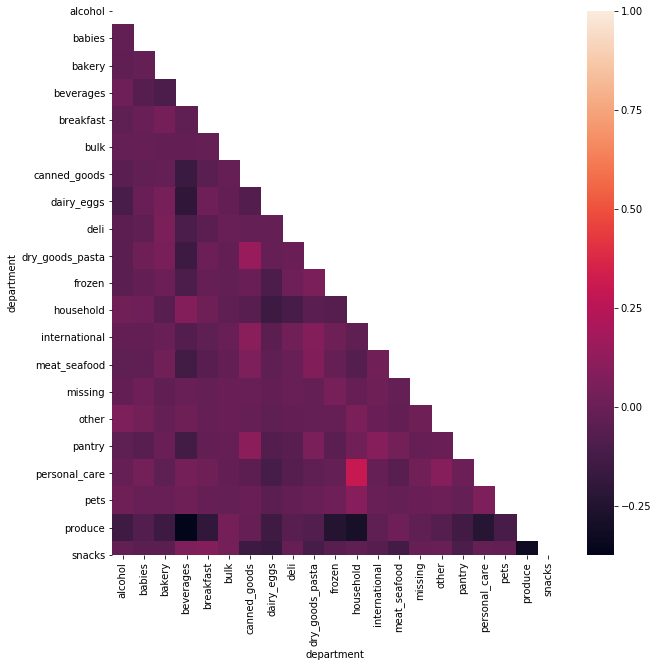

In [12]:
# Same data but each user is normalized to percent to account for total items bought
plt.figure(figsize=(10,10))
matrix_ = np.triu(dept_percent_df.corr())
sns.heatmap(dept_percent_df.corr(), mask=matrix_)

### Conclusions from Correlation
- High correlation of produce, dairy/eggs, and pantry items
- Babies does not have any strong correlation
    - highest corr is 0.289, dairy/eggs
- Dairy/Eggs correlates with many other categories
- Alcohol, pets, missing and other don't have any strong correlations
    - all less than 0.25



### Clustering on Users based on items bought per department

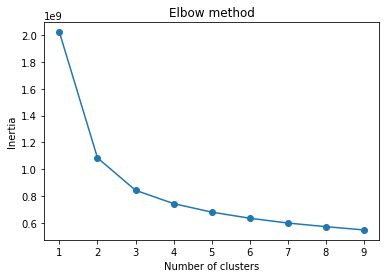

In [18]:
kmeans = KMeans()
plot_inertia(kmeans, dept_user_df, range(1, 10))

In [24]:
# K-means for using 9 clusters
pd.Series(kmeans.labels_).value_counts()

2    112472
6     46534
0     18797
4     10379
3      7321
7      5130
1      3870
5      1052
8       654
dtype: int64

In [28]:
# Labelling for clustering (n=4) based on departments
kmeans.set_params(n_clusters=4)
kmeans.fit(dept_user_df)
pd.Series(kmeans.labels_).value_counts()

1    144304
3     43066
0     14826
2      4013
dtype: int64

#### Only cluster 2 seems to be good. The other are split and the average silhouette is fairly low (~0.43)

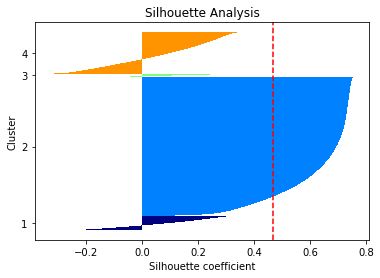

In [27]:
plot_silhouette(kmeans, dept_user_df)

## PCA followed by K-Means

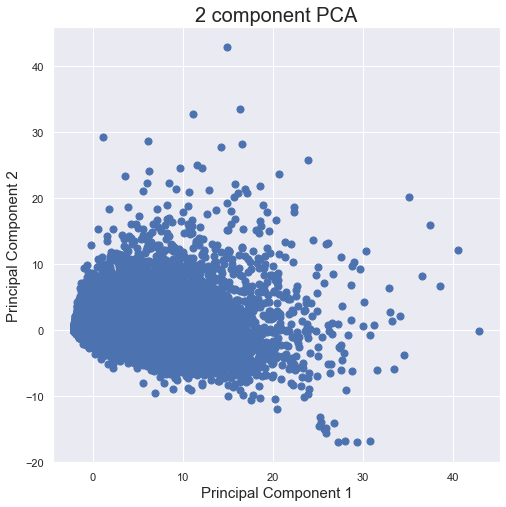

In [148]:
# Run PCA on raw items bought per department per user. User_id not included in PCA bc it's the index
dept_user_df_raw = dept_user_df.drop(labels='total_items', axis=1)
pca_raw_explained_variance_ratio = plot_PCA(dept_user_df_raw)

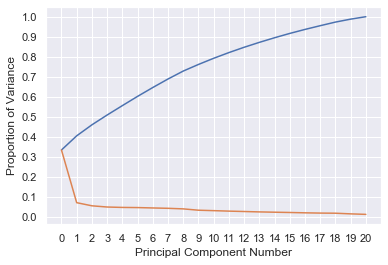

In [170]:
# Scree Plot of Principal Components to decide how many to include in KMeans
cum_sum_pca_var = np.cumsum(pca_raw_explained_variance_ratio)
x = np.arange(0,21)

plt.plot(x, cum_sum_pca_var, label='Cumulative Variance')
plt.plot(x, pca_raw_explained_variance_ratio, label= 'Variance')
plt.xlabel('Principal Component Number')
plt.ylabel('Proportion of Variance')
plt.xticks(np.arange(0,21))
plt.yticks(np.arange(0,1.1,0.1))
plt.show()

In [187]:
dept_user_pca_df = plot_PCA(dept_user_df, return_df=True)
plt.clf()

<Figure size 576x576 with 0 Axes>

In [191]:
# Dataframe with 80% of variance from first 10 components
pca_df_10_components = dept_user_pca_df[np.arange(11)]

# Dataframe with 90% of variance from first 14 components
pca_df_14_components = dept_user_pca_df[np.arange(15)]


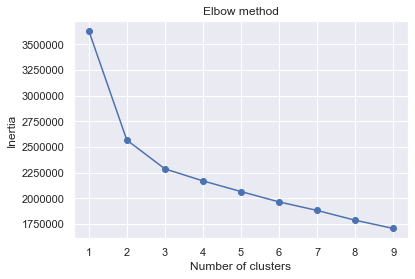

In [192]:
kmeans_pca = KMeans()
plot_inertia(kmeans_pca, pca_df_10_components, range(1, 10))

In [194]:
kmeans_pca.set_params(n_clusters=4)
kmeans_pca.fit(pca_df_10_components)
pd.Series(kmeans_pca.labels_).value_counts()

1    140634
0     45898
2     15836
3      3841
dtype: int64

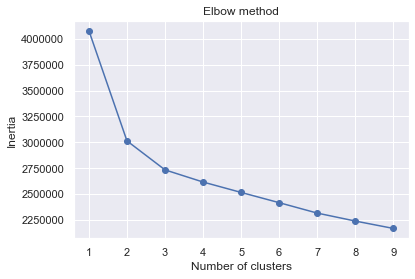

In [195]:
kmeans_pca_14 = KMeans()
plot_inertia(kmeans_pca_14, pca_df_14_components, range(1, 10))

In [197]:
kmeans_pca_14.set_params(n_clusters=4)
kmeans_pca_14.fit(pca_df_14_components)
pd.Series(kmeans_pca_14.labels_).value_counts

<bound method IndexOpsMixin.value_counts of 0         0
1         2
2         0
3         0
4         0
         ..
206204    0
206205    2
206206    2
206207    3
206208    0
Length: 206209, dtype: int32>

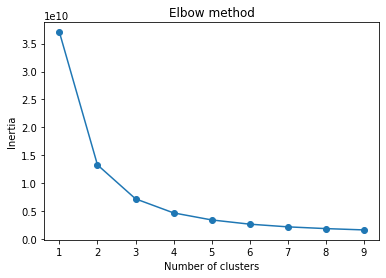

In [49]:
# Inertia plot of all components
plot_inertia(kmeans, dept_user_pca_df, range(1, 10))

In [50]:
kmeans.set_params(n_clusters=4)
kmeans.fit(dept_user_pca_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [54]:
# K-Means results using all components
pd.Series(kmeans.labels_).value_counts()

1    141711
3     44727
0     15717
2      4054
dtype: int64

# Part 2. Identify Sub-populations of customers based on items bought
1. Parents: ~35,000 shoppers who buy baby items
2. Pet owners: ~15,500 shoppers who buy pet items
3. Drinkers: ~16,000 shoppers who buy alcohol

#### Groups are fairly distinct
1. 90% of parents dont have pets
2. 94% of parents don't buy alcohol
3. 86% of drinkers don't buy pet items

In [7]:
# 34782 shoppers bought baby items
# Max = 821, Mean = 12.6, Median = 4 
parents = dept_user_df[dept_user_df.babies >0]
parents.to_csv('../data/parents.csv')
# 15484 shoppers who bought pet items
# Max = 522
# Median = 3, Mean = 6.6
pet_owners = dept_user_df[dept_user_df.pets >0]
pet_owners.to_csv('../data/pet_owners.csv')
# 16104 shoppers bought alcohol
# One shopper bought 685 alcohol items
# median = 4, avg = 9.9
drinkers = dept_user_df[dept_user_df.alcohol >0]
drinkers.to_csv('../data/drinkers.csv')

In [14]:
# Calculate percent of users that overlap in other groups
# Example: Number of drinkers who do not buy pet items
drinkers.pets.value_counts()[0]/drinkers.shape[0]

0.8569920516641828

In [16]:
# Concatenate parents, pet_owners and drinkers, Expected shape = 66370 (34782+15484+16104)
df_list = [parents, pet_owners, drinkers]
subgroups_df = pd.concat(df_list)
subgroups_df.shape

(66370, 21)

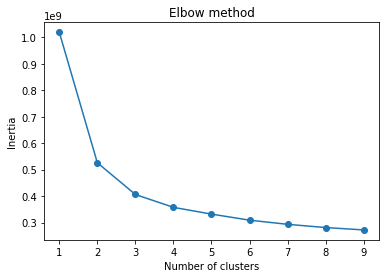

In [20]:
kmeans = KMeans()
plot_inertia(kmeans, subgroups_df, range(1, 10))

In [21]:
kmeans.set_params(n_clusters=3)
kmeans.fit(subgroups_df)

pd.Series(kmeans.labels_).value_counts()

0    49049
2    13630
1     3691
dtype: int64

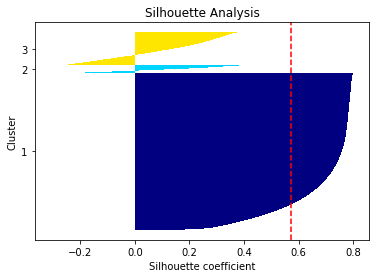

In [22]:
plot_silhouette(kmeans, dept_user_df)

### K-means does not pick out the same clusters that I did (parents, pet owners, drinkers)
1. Distribution of labels is not the same as the ground truth
2. 2 Clusters do not seem appropriate based on silhouette
3. But getting less inertia than clustering on the full department data


[0.35544616 0.07681879 0.05004922 0.04871851 0.04639032 0.04429849
 0.04218555 0.04010953 0.03667281 0.03282921 0.03003704 0.02642
 0.02560031 0.02374207 0.02154841 0.02078799 0.01892591 0.01846154
 0.01664407 0.01421688 0.01009719]


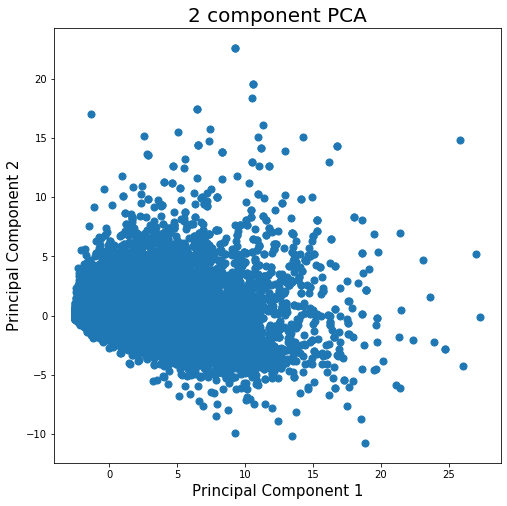

In [24]:
plot_PCA(subgroups_df)

# Part 3. Hierarchical Clustering of Users by Department

#### Randomly Sampling Dataset to reduce to 20,000 observations

1. Can see some clusters

#### K-means clustering to reduce datapoints

1. Hierarchical clustering on 200k datapoints will require too much memory so use K-means to reduce the resolution
2. Also use MiniBatchKmeans to increase speed
    - Requirement: batch_size > n_clusters     
2. Determining number of clusters to use:
    - Minibatch with k = sqrt(n) aka 450, batch = 1000 was good
    - Minibatch: (n_clusters=20000, batch_size=25000), large variety in number obs per bin based on histogram
    - Minibatch: (n_clusters=2000,batch_size=3000), better distribution of obs within clusters but didn't cluster as clearly
    - Minibatch: (n_clusters=800, batch_size=1000), nice distribution and clustering. Using this going forward    
3. Cluster only on 8 columns that contain majority of information
4. Data is scaled by row, (percentage items bought per department)
    - scaling 800,1000 by columns did not improve clustering



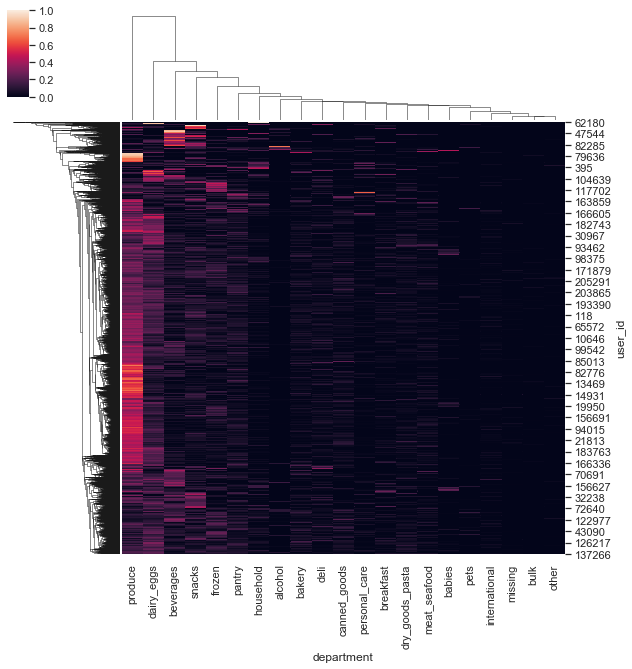

In [123]:
# Take 20,000 random user_ids and perform Hierarchical clustering
import seaborn as sns; sns.set(color_codes=True)

users_random_sample = dept_percent_df.sample(20000, random_state=42)
g = sns.clustermap(users_random_sample)

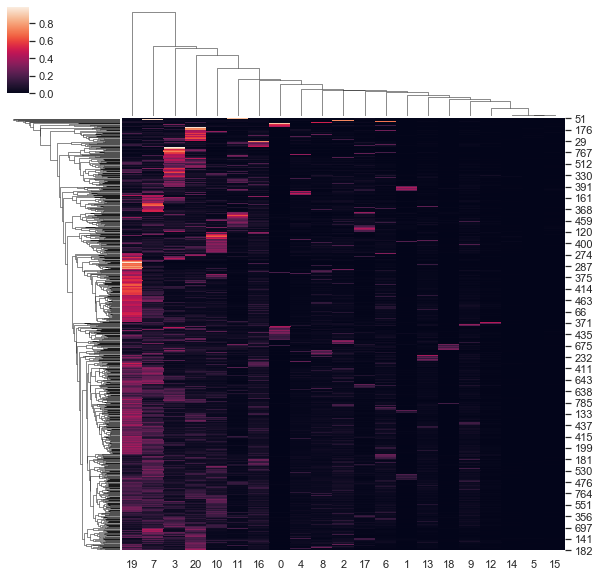

In [126]:
# Clustering on full dataset
from sklearn.cluster import MiniBatchKMeans
kmeans =  MiniBatchKMeans(n_clusters=800, random_state=42,batch_size=1000)
kmeans.fit(dept_percent_df)

sns.clustermap(kmeans.cluster_centers_)

Text(0, 0.5, 'Number of Observations')

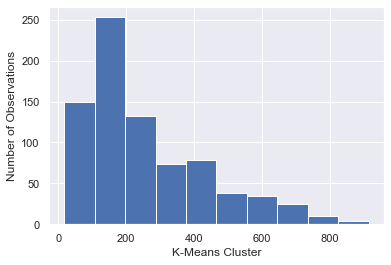

In [125]:
plt.hist(pd.Series(kmeans.labels_).value_counts())
plt.xlabel('K-Means Cluster')
plt.ylabel('Number of Observations')

In [41]:
pd.Series(dept_percent_df.columns)

0             alcohol
1              babies
2              bakery
3           beverages
4           breakfast
5                bulk
6        canned_goods
7          dairy_eggs
8                deli
9     dry_goods_pasta
10             frozen
11          household
12      international
13       meat_seafood
14            missing
15              other
16             pantry
17      personal_care
18               pets
19            produce
20             snacks
Name: department, dtype: object

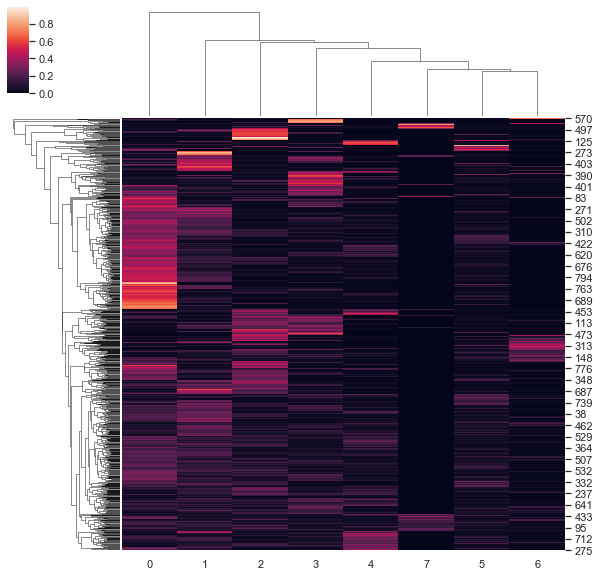

In [108]:
# Cluster on 8 departments only

col_list = [19,7,3,20,10,16,11,0]
name_list = dept_percent_df.columns.tolist()

sub_cols = [name_list[i] for i in col_list]

kmeans_8 =  MiniBatchKMeans(n_clusters=800, random_state=42,batch_size=1000)
kmeans_8.fit(dept_percent_df[sub_cols])

g = sns.clustermap(kmeans_8.cluster_centers_,)

(array([150., 253., 132.,  74.,  79.,  38.,  35.,  25.,  10.,   4.]),
 array([ 18. , 107.6, 197.2, 286.8, 376.4, 466. , 555.6, 645.2, 734.8,
        824.4, 914. ]),
 <a list of 10 Patch objects>)

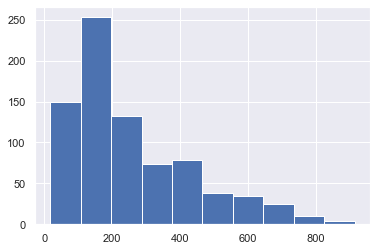

In [109]:
plt.hist(pd.Series(kmeans_8.labels_).value_counts())

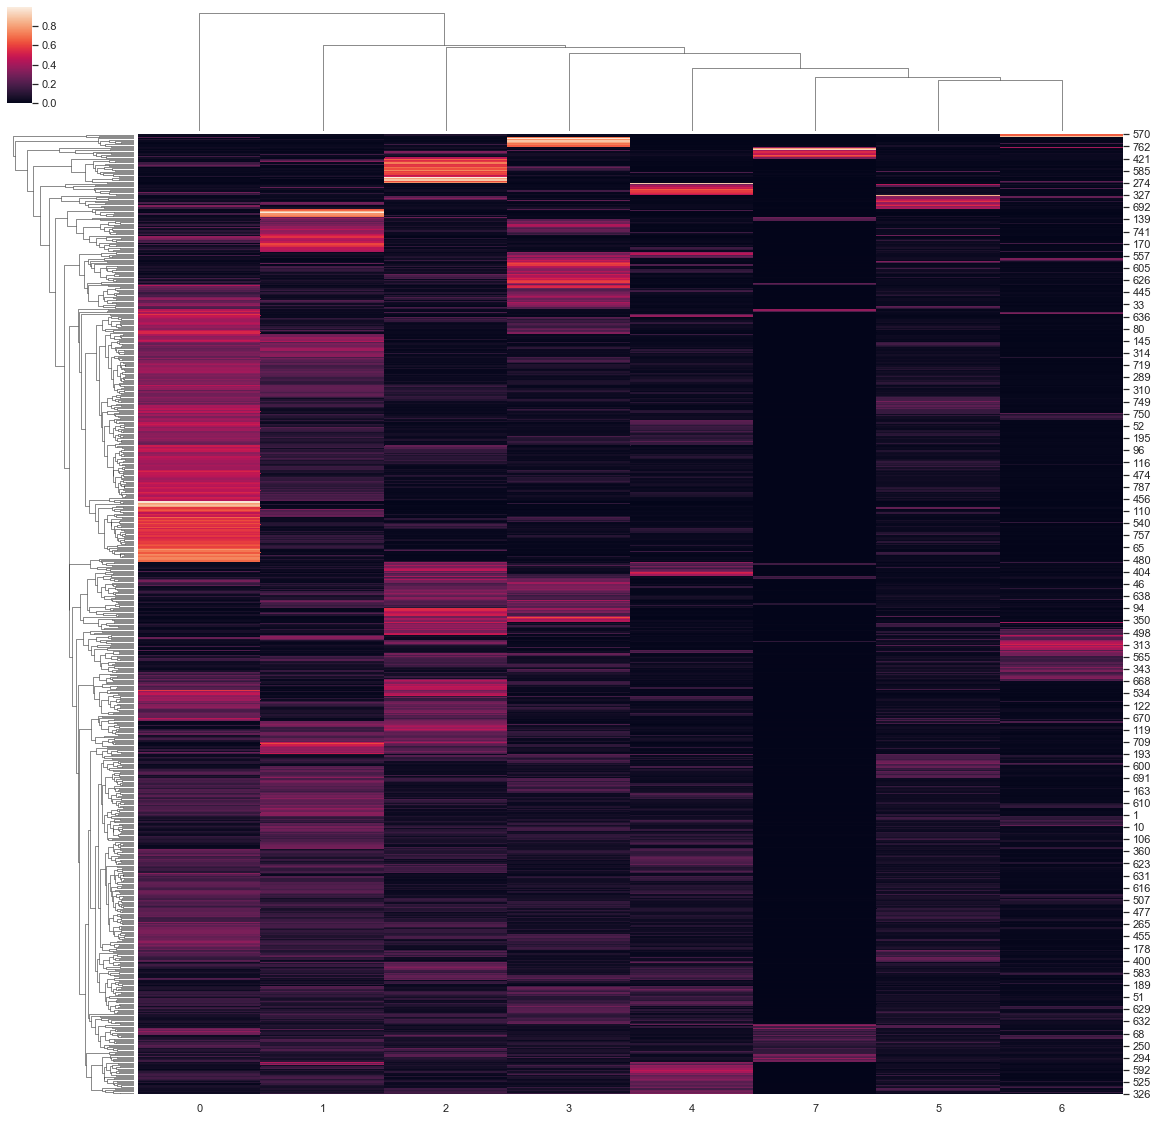

In [89]:
g = sns.clustermap(kmeans_8.cluster_centers_, figsize=(20,20))

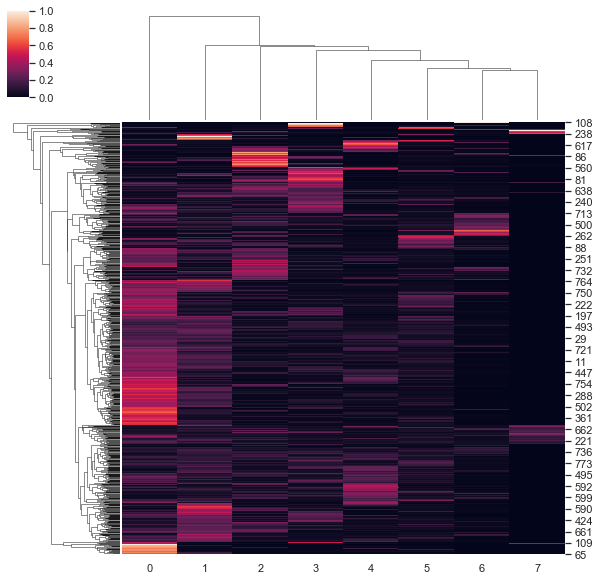

In [94]:
# See how clustering changes after scaling the columns
sns.clustermap(kmeans_8.cluster_centers_, standard_scale=1)

In [110]:
# Get the order of clustered rows using kmeans_8
dendrogram_rows_8 = g.dendrogram_row.reordered_ind

(array([150., 253., 132.,  74.,  79.,  38.,  35.,  25.,  10.,   4.]),
 array([ 18. , 107.6, 197.2, 286.8, 376.4, 466. , 555.6, 645.2, 734.8,
        824.4, 914. ]),
 <a list of 10 Patch objects>)

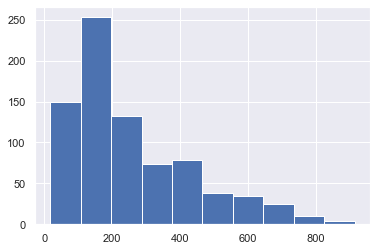

In [113]:
# Map kmeans clusters to user_id 
kmeans_groups_to_userid = pd.Series(kmeans_8.labels_)
kmeans_groups_to_userid.index = np.arange(1, len(kmeans_groups_to_userid) + 1)


### Future Work:
1. PCA then K-Means on Jordan's data (maybe)
2. Extract clusters from hierarchical clustering and map back to user_ids
    - use the scipy.dendrogram to establish cutoffs 
    - https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html
3. Explore K-means clustered data to try to find interpretable insights

In [5]:
orders_fa = pd.read_csv('../data/orders_fa.csv')

MemoryError: 

In [4]:
from sklearn.cluster import MiniBatchKMeans
kmeans =  MiniBatchKMeans(n_clusters=8000, random_state=42,batch_size=10000)
kmeans.fit(dept_percent_df)



NameError: name 'sns' is not defined

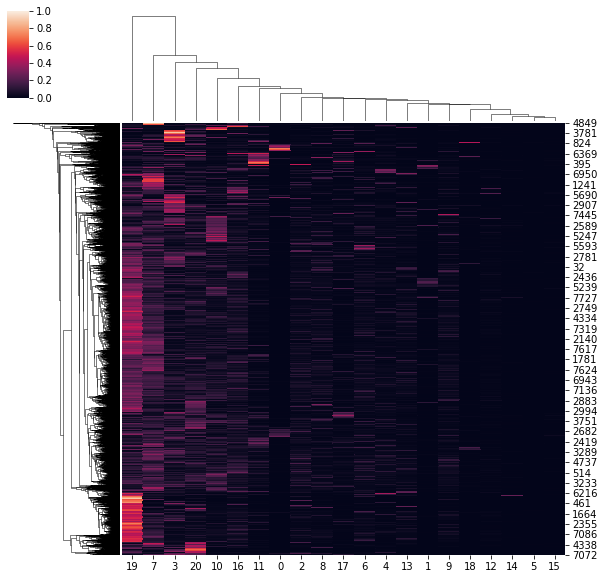

In [6]:
g = sns.clustermap(kmeans.cluster_centers_)

2310    381
1015    261
98      136
19      125
4288    111
       ... 
3868      3
5242      3
5308      3
4605      2
5480      2
Length: 8000, dtype: int64

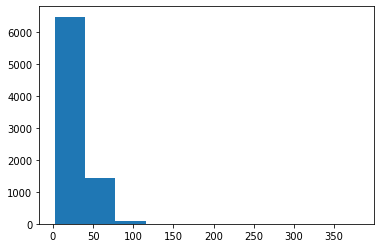

In [8]:
plt.hist(pd.Series(kmeans.labels_).value_counts())
pd.Series(kmeans.labels_).value_counts()

In [16]:
col_list = [19,7,3,20,10,16,11,0]
name_list = dept_percent_df.columns.tolist()

sub_cols = [name_list[i] for i in col_list]

kmeans_8 =  MiniBatchKMeans(n_clusters=250, random_state=42,batch_size=1000)
kmeans_8.fit(dept_percent_df[sub_cols])

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=250, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

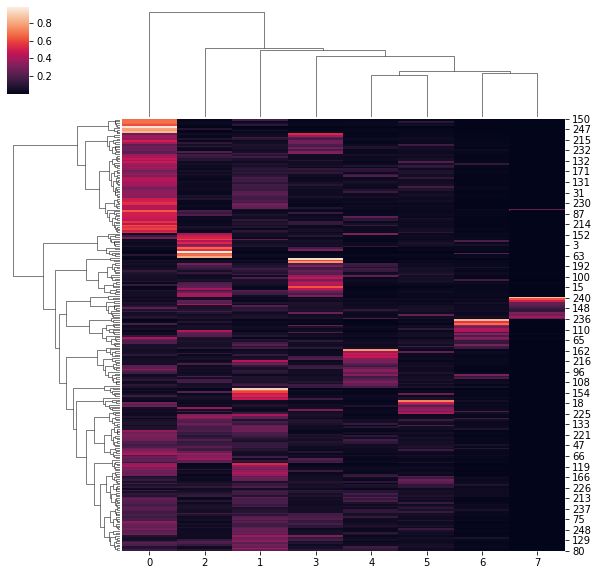

In [24]:
g_80 = sns.clustermap(kmeans_8.cluster_centers_, method='ward')

In [32]:
dgram = g_80.dendrogram_row.dendrogram
D = np.array(dgram['dcoord'])
I = np.array(dgram['icoord'])

# then the root node will be the last entry, and the length of the L/R branches will be
yy = D[-1] 
lenL = yy[1]-yy[0]
lenR = yy[2]-yy[3]

row_linkage = g_80.dendrogram_row.linkage

In [40]:
len(D)

249

89     2512
70     2493
8      2360
230    2354
207    2327
       ... 
204     113
18      101
235      91
62       67
139      50
Length: 250, dtype: int64

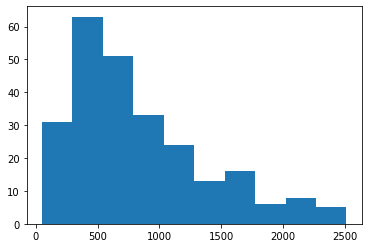

In [25]:
plt.hist(pd.Series(kmeans_8.labels_).value_counts())
pd.Series(kmeans_8.labels_).value_counts()

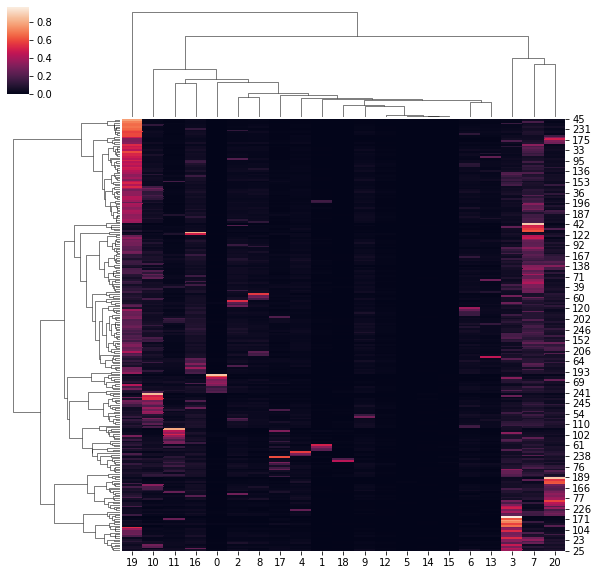

In [26]:
kmeans_all_250_1000 =  MiniBatchKMeans(n_clusters=250, random_state=42,batch_size=1000)
kmeans_all_250_1000.fit(dept_percent_df)

g_all_250_1000 = sns.clustermap(kmeans_all_250_1000.cluster_centers_, method='ward')

In [27]:
col_list = [19,7,3,20,10,16,11,0]
name_list = dept_percent_df.columns.tolist()

sub_cols = [name_list[i] for i in col_list]

kmeans_500 =  MiniBatchKMeans(n_clusters=500, random_state=42,batch_size=1000)
kmeans_500.fit(dept_percent_df[sub_cols])

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=500, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

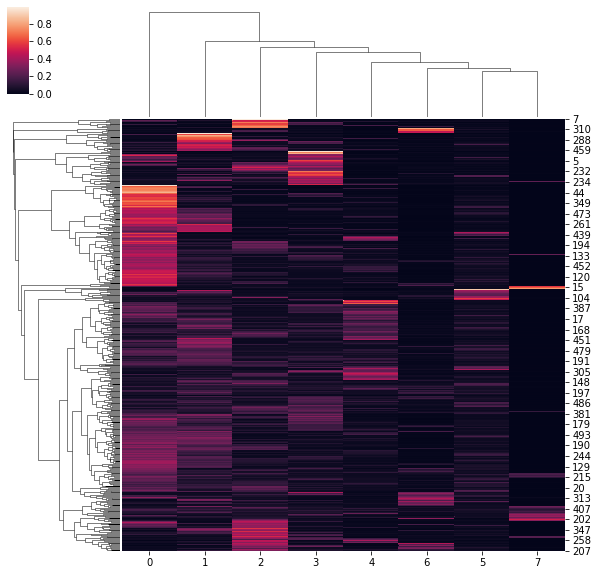

In [30]:
g_500 = sns.clustermap(kmeans_500.cluster_centers_, method='complete')